# Fractional Cover: Trend and Variability Analysis

**Note:** As of August 2018, this notebook requires modification in order to run successfully. Please contact the author (Chad Burton) for assistance prior to running any analyses.

**<font color=green>Contents</font>**

[Description and readme](#readme)

[User Inputs](#userInputs)

[Custom functions](#functions)

1. [Pixel-wise trend and variability analysis](#pixelWiseAnalysis)

    1.1 [Extract data](#get_data)
    
    1.2 [Masking](#masking)
    
    1.3 [CDO operations](#CDO_operations)
    
    1.4 [Statistical Tests](#welch-test)
    
    1.5 [Composite RGB](#rgb_plot)
    
    1.6 [Export geotiffs](#export_geotiffs)

2. [Zonal statistics](#zonalStats)

3. [Reporting and plotting](#reporting)

    3.1 [Zonal timeseries plots](#timeseries)
    
    3.2 [Pixel-wise plots](#pixel-wise_plots)
    
    3.3 [True Colour plot](#truecolourplot)
    
    3.4 [Merge all PDFs](#mergeallpdfs)

**<font color=green>Description/Readme</font>**
<a id="readme"> </a>

**Summary:**

This script conducts exploratory timeseries analysis on the Fractional Cover dataset (stored in the Geoscience Australia DataCube) in order to help detect, but not attribute, change in vegetation coverage from seasonal grasss to perennial shrubs and trees.  The script conducts the following analysis:

1. Pixel-wise trend and variability analysis to produce outputs of linear coefficients since some reference time, the change in seasonal and interannual variability between a baseline period and a more recent period, and the difference in mean total vegetation (PV + NPV) between a baseline period and more recent period.

2. Zonal statistics for n polygons within a shapefile.

3. Pixel-wise statistical tests to determine where change is significant, these test are applied to both the means (Welch T-test), and the variance (Levene test).

4. Lastly, an RGB composite map is produced whose bands include: the difference in means, the difference in variability, and the welch-test probabilities.  This final map shows regions where strong regeneration from emphemeral pasture to perrenial trees is likely to have occurred.  

The script relies heavily on the Climate Data Operators (CDO) library to conduct the analysis, which requires loading CDO in the terminal
before using this script (run: module load cdo/1.7.1), and installation of the CDO python wrapper. Visit https://github.com/Try2Code/cdo-bindings for instructions on installing CDO-python through the pip installer (this only needs to be done once).

The python packages PyPDF2, and rasterstats are also required and are not pre-installed on the VDI.

Custom modules are also used throughout the script and are available for download from the Geoscience Australia github page https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/algorithms. These include:

<font color=cyan>*array_to_geotiff, rasterize_vector, load_masked_FC, dataset_to_geotiff, three_band_image, load_clearlandsat</font>*

*Update:* These functions are now included at the start of the script after the user inputs section (the script is vastly longer but it doesn't require any installation of custom modules).

The user should go to the 'user inputs' sections at the top of the script and enter the relevant information. Thereafter, the
script should not need editing.  It is required that a shapefile defining the boundaries for the area of interest is supplied. The shapefile needs some preprocessing before it will run effectively, read part 2 below for more details.

**Part 1:**

The first part of this script conducts pixel-wise time-series analysis on the fractional cover dataset over a region defined by an input shapefile.

Depending on the size of the region of interest, this script could be run on Raijin to speed up its processing. However, with Dask implemented
it will run (almost) any size analysis through the VDI.  The script is raijin friendly so exporting it to a .py file should be fine.

*Nb: Piping of CDO operations is throwing an error, so each step in the analysis is seperated. Piping speeds up the analysis so I should try to resolve this when I get a chance*

**Part 2:**

The second part of this script calculates the zonal mean and zonal standard deviation (std dev of the pixel values within the polygon - indication of the range of values within the polygon) of Total Vegetation (PV + NPV) over each seperate polygon in the input shapefile.

**This step requires some pre-processing of the input shapefile: an attribute column uniquely identifying ecah polygon must be included. The name of the attribute column needs to be declared in the 'user inputs' section. Place this shapefile in your 'data' directory.**

**Part 3:**

All results are compiled into a pdf document (called 'final_results.pdf') that contains
 - A true colour map of the area of interest with the shapefile overlaying it
 - The zonal timeseries for each polygon 
 - Pixel-wise plots showing: the difference between the intra-annual variability in the baseline period compared with the recent period, the         levene test p-values, the difference between the mean TV in the basline period and recent period, and Welsh T-test p values on the mean differences
 - A binary classification map showing the regions at high-risk of no-regeneration (based on the difference in variability map), and the same plot but masked just to those regions with a levene test p-value <=0.1. The binary classification map is a boolean map of 1's and 0's.  A 1 indicates areas where regeneration is unlikely to have occurred (areas where the intra-annual variability is higher in the recent period than during the baseline period, likely indicating there has been no transition from highly seasonal grasses to less climate responsive perennial vegetation (trees and shrubs).
 - And finally the RGB plot that can be used to find regions where strong regeneration is occurring (regions that are white in the map).



This code was written in April/May of 2018 by Chad Burton, with significant and invaluable help from everyone in Team X and Team Wombat. The notebook was completed as a graduate program project at Geoscience Australia.

## Import libraries

In [1]:
#Bring in libraries
import datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.masking import make_mask

import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import gdal

import sys
import os
# sys.path.append(os.path.abspath('/g/data/u46/users/cb3058/fc_changeDetection/src'))
# sys.path.append(os.path.abspath('/g/data/u46/users/cb3058/fc_changeDetection/'))
# from src import array_to_geotiff
# from src import rasterize_vector
# from src import load_nbarx
# from src import load_masked_FC
# from src import dataset_to_geotiff
# from src import three_band_image

import netCDF4
from cdo import *
cdo=Cdo()
cdo.CDO = '/apps/cdo/1.7.1/bin/cdo'     #need to update the location of cdo or else the wrapper can't find cdo.exe

## USER INPUTS
<a id="userInputs"> </a>

In [2]:
#enter the filepath locations of the data, results, and working directory (location where you're running the script from)
results = '/g/data/u46/users/cb3058/fc_changeDetection/results/'
working_directory = '/g/data/u46/users/cb3058/fc_changeDetection/'
data = working_directory + 'data/'

#Enter the name of project area of interest (string)
project_ID = 'Canberra'

#Add the filepaths for the project shapefile (string)
shapefile_loc = data + 'Canberra.shp' 

#name of the attribute column in the shapefile with the uniquely labelled polygons (string)
feature_name= 'FeatureNam'

#start and end date of the timeseries of interest (usually shouldn't need to change this)
start_date = '1988-01-01'
end_date = '2017-12-31'

#enter the year from which regeneration is supposed to have started 
#(i.e. often the model start date, or the date from which land-use changes begun)
start_of_regen= '2012'

#enter the baseline period (longer is better, but is often 10 years)
start_of_baseline = '2002'
end_of_baseline = '2011' 

#set the number of chunks to pass to dask 
#(bigger chunks will run the dc_load faster, but be careful of hitting memory limits)
ds_chunks = 40

## Set cloud threshold. This value defines the amount of lansdcape/cloud allowed in each scene. 
#Scenes will not be retrieved that have less than the cloud threshold worth of image.
cloud_free_threshold = 0.80


## Custom functions
<a id="functions"> </a>

In [3]:
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
import gdal
import numpy as np
import xarray as xr
import rasterio
def load_clearlandsat(dc, query, masked_prop=0.99, sensors=['ls5', 'ls7', 'ls8'], mask_dict=None):

    # List to save results from each sensor
    filtered_sensors = []

    # Iterate through all sensors, returning only observations with > mask_prop clear pixels
    for sensor in sensors:
        
        try:

            # Lazily load Landsat data using dask
            print('Loading {} PQ'.format(sensor))
            data = dc.load(product = '{}_nbart_albers'.format(sensor),
                        group_by = 'solar_day', 
                        dask_chunks={'time': 1},
                        **query)

            # Remove measurements variable from query so that PQ load doesn't fail
            pq_query = query.copy()
            if 'measurements' in pq_query: del pq_query['measurements']

            # Load PQ data
            pq = dc.load(product = '{}_pq_albers'.format(sensor),
                         group_by = 'solar_day',
                         fuse_func=ga_pq_fuser,
                         **pq_query)

            # Return only Landsat observations that have matching PQ data (this may
            # need to be improved, but seems to work in most cases)
            data = data.sel(time = pq.time, method='nearest')
            
            # If a custom dict is provided for mask_dict, use these values to make mask from PQ
            if mask_dict:
                
                # Mask PQ using custom values by unpacking mask_dict **kwarg
                good_quality = masking.make_mask(pq.pixelquality, **mask_dict)
                
            else:

                # Identify pixels with no clouds in either ACCA for Fmask
                good_quality = masking.make_mask(pq.pixelquality,
                                                 cloud_acca='no_cloud',
                                                 cloud_fmask='no_cloud',
                                                 contiguous=True)

            # Compute good data for each observation as a percentage of total array pixels
            data_perc = good_quality.sum(dim=['x', 'y']) / (good_quality.shape[1] * good_quality.shape[2])
            
            # Add data_perc data to Landsat dataset as a new xarray variable
            data['data_perc'] = xr.DataArray(data_perc, [('time', data.time)])

            # Filter and finally import data using dask
            filtered = data.where(data.data_perc >= masked_prop, drop=True)
            print('    Loading {} filtered {} timesteps'.format(len(filtered.time), sensor))
            filtered = filtered.compute()
            
            # Append result to list
            filtered_sensors.append(filtered)
        
        except:
            
            # If there is no data for sensor or if another error occurs:
            print('    Skipping {}'.format(sensor))

    # Concatenate all sensors into one big xarray dataset, and then sort by time
    print('Combining and sorting ls5, ls7 and ls8 data')
    combined_ds = xr.concat(filtered_sensors, dim='time')
    combined_ds = combined_ds.sortby('time')
    
    # Return combined dataset
    return combined_ds



import datacube
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.masking import make_mask

dc = datacube.Datacube(app='fc_fun')

def load_masked_FC(sensor, query, cloud_free_threshold):   
    #print('loading {}'.format(sensor)
    
    basic_pq_mask = {'cloud_acca':'no_cloud',
    'cloud_shadow_acca' :'no_cloud_shadow',
    'cloud_shadow_fmask' : 'no_cloud_shadow',
    'cloud_fmask' :'no_cloud',
    'blue_saturated' : False,
    'green_saturated' : False,
    'red_saturated' : False,
    'nir_saturated' : False,
    'swir1_saturated' : False,
    'swir2_saturated' : False,
    'contiguous':True,
    'land_sea': 'land'}

    # load FC and PQ
    fc = dc.load(product=(sensor + '_fc_albers'), group_by='solar_day', **query)
    pq = dc.load(product=(sensor + '_pq_albers'), group_by='solar_day', **query, fuse_func=ga_pq_fuser)

    crs = fc.crs
    crswkt = fc.crs.wkt
    affine = fc.affine

    # find common observations
    time = (fc.time - pq.time).time  # works!
    fc = fc.sel(time=time)
    pq = pq.sel(time=time)

    # mask
    basic_mask = make_mask(pq, **basic_pq_mask).pixelquality
    fc = fc.where(basic_mask)    
    cloud_free = make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud').pixelquality

    #filter with cloud free threshold to remove cloudy scenes
    mostly_cloud_free = cloud_free.mean(dim=('x', 'y')) >= cloud_free_threshold

    # only those observations that were mostly cloud free
    result = fc.where(mostly_cloud_free).dropna(dim='time', how='all')
    result.attrs['crs'] = crs
    result.attrs['affine'] = affine
    return result
        
    print ('complete')

    
import gdal
import numpy as np

def rasterize_vector(input_data, cols, rows, geo_transform,
                     projection, field=None, raster_path=None):
    """
    Rasterize a vector file and return an array with values for cells that occur within the shapefile. 
    Can be used to obtain a binary array (shapefile vs no shapefile), or can assign the array cells with
    values from the shaepfile features by supplying the name of a shapefile field ('field). If 'raster_path' 
    is provided, the resulting array can be output as a geotiff raster.
    
    This function requires dimensions, projection data (in "WKT" format) and geotransform info 
    ("(upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size)") for the output array. 
    These are typically obtained from an existing raster using the following GDAL calls:
    
    # import gdal
    # gdal_dataset = gdal.Open(raster_path)
    # geotrans = gdal_dataset.GetGeoTransform()
    # prj = gdal_dataset.GetProjection()
    # out_array = gdal_dataset.GetRasterBand(1).ReadAsArray() 
    # yrows, xcols = out_array.shape
    
    Last modified: April 2018
    Author: Robbi Bishop-Taylor

    :attr input_data: input shapefile path or preloaded GDAL/OGR layer
    :attr cols: desired width of output array in columns. This can be obtained from an existing
                array using '.shape[0]')
    :attr rows: desired height of output array in rows. This can be obtained from an existing
                array using '.shape[1]')
    :attr geo_transform: geotransform for output raster; 
                 e.g. "(upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size)"
    :attr projection: projection for output raster (in "WKT" format)
    :attr field: shapefile field to rasterize values from. If none given (default), this 
                 assigns a value of 1 to all array cells within the shapefile, and 0 to 
                 areas outside the shapefile

    :returns: a 'row x col' array containing values from vector
    """

    # If input data is a string, import as shapefile layer
    if isinstance(input_data, str):
        # Open vector with gdal
        data_source = gdal.OpenEx(input_data, gdal.OF_VECTOR)
        input_data = data_source.GetLayer(0)

    # If raster path supplied, save rasterized file as a geotiff
    if raster_path:

        # Set up output raster
        print('Exporting raster to {}'.format(raster_path))
        driver = gdal.GetDriverByName('GTiff')
        target_ds = driver.Create(raster_path, cols, rows, 1, gdal.GDT_UInt16)

    else:

        # If no raster path, create raster as memory object
        driver = gdal.GetDriverByName('MEM')  # In memory dataset
        target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)

    # Set geotransform and projection
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)

    # Rasterize shapefile and extract array using field if supplied; else produce binary array
    if field:
        gdal.RasterizeLayer(target_ds, [1], input_data, options=["ATTRIBUTE=" + field])
    else:
        gdal.RasterizeLayer(target_ds, [1], input_data)    
    
    band = target_ds.GetRasterBand(1)
    out_array = band.ReadAsArray()
    target_ds = None

    return out_array


from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt

def three_band_image(ds, bands, time = 0, figsize = [10, 10], contrast_enhance = False,
                     title = 'Time'):
    """
    threeBandImage takes three spectral bands and plots them on the RGB bands of an 
    image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause, Cate Kooymans
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    contrast_enhance - determines the transformation for plotting onto RGB. If contrast_enhance = true, 
                       exposure.equalize_hist is used to trasnform the data. Else, the data are
                       standardised relative to reflectance = 5000.
    title - string for the plot title. If nothing is given, it will print the names of the
            bands being plotted.
    projection - options are 'projected' or 'geographic'. To determine if the image is
                in degrees or northings
    """

    try:
        t, y, x = ds[bands[0]].shape
        rawimg = np.zeros((y, x, 3), dtype = np.float32)
        for i, colour in enumerate(bands):
            rawimg[:, :, i] = ds[colour][time].values
    except ValueError:
        y, x = ds[bands[0]].shape
        rawimg = np.zeros((y, x, 3), dtype = np.float32)
        for i, colour in enumerate(bands):
            rawimg[:, :, i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    if contrast_enhance is True:
        img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    else:
        img_toshow = rawimg
    fig = plt.figure(figsize = figsize)
    plt.imshow(img_toshow, extent = [ds.coords['x'].min(), ds.coords['x'].max(),
                          ds.coords['y'].min(), ds.coords['y'].max()])
    ax = plt.gca()
    if title == 'Time':
        try:
            ax.set_title(str(ds.time[time].values), fontweight = 'bold', fontsize = 16)
        except:
            ax.set_title('', fontweight = 'bold', fontsize = 16)
    else:
        ax.set_title(title, fontweight = 'bold', fontsize = 16)
    return plt, fig


import gdal
import numpy as np

def array_to_geotiff(fname, data, geo_transform, projection,
                     nodata_val=0, dtype=gdal.GDT_Float32):
    """
    Create a single band GeoTIFF file with data from an array. 
    
    Because this works with simple arrays rather than xarray datasets from DEA, it requires
    geotransform info ("(upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size)") and 
    projection data (in "WKT" format) for the output raster. These are typically obtained from 
    an existing raster using the following GDAL calls:
    
    # import gdal
    # gdal_dataset = gdal.Open(raster_path)
    # geotrans = gdal_dataset.GetGeoTransform()
    # prj = gdal_dataset.GetProjection()
    
    ...or alternatively, directly from an xarray dataset:
    
    # geotrans = xarraydataset.geobox.transform.to_gdal()
    # prj = xarraydataset.geobox.crs.wkt
    
    Last modified: March 2018
    Author: Robbi Bishop-Taylor
    
    :attr fname: output file path
    :attr data: input array
    :attr geo_transform: geotransform for output raster; 
    			 e.g. "(upleft_x, x_size, x_rotation, upleft_y, y_rotation, y_size)"
    :attr projection: projection for output raster (in "WKT" format)
    :attr nodata_val: value to convert to nodata in output raster; default 0
    :attr dtype: value to convert to nodata in output raster; default gdal.GDT_Float32
    """

    # Set up driver
    driver = gdal.GetDriverByName('GTiff')

    # Create raster of given size and projection
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, dtype)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)

    # Write data to array and set nodata values
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    band.SetNoDataValue(nodata_val)

    # Close file
    dataset = None

    
import gdal
import numpy as np
import xarray as xr
import rasterio

def dataset_to_geotiff(filename, data):
    kwargs = {'driver': 'GTiff',
              'count': len(data.data_vars),  # geomedian no time dim
              'width': data.sizes['x'], 'height': data.sizes['y'],
              'crs': data.crs.crs_str,
              'transform': data.affine,
              'dtype': list(data.data_vars.values())[0].values.dtype,
              'nodata': 0,
              'compress': 'deflate', 'zlevel': 4, 'predictor': 3}
    with rasterio.open(filename, 'w', **kwargs) as src:
        for i, band in enumerate(data.data_vars):
            src.write(data[band].data, i + 1)

# Pixel-wise trend and variability analysis
<a id="pixelWiseAnalysis"> </a>
Functioning code, nothing should need to be changed from here onwards

## Get Fractional Cover dataset from the DataCube
<a id="get_data"> </a>

In [4]:
#create subdirectories in the results folder for all the outputs
#folder in results labelled by the project_ID
os.makedirs(results+ project_ID)
#netcdfs
os.makedirs('results/' + project_ID + '/netcdfs')
#tiffs
os.makedirs('results/' + project_ID + '/geotiffs')
#pdfs (seperate folder for the timeseries plots)
os.makedirs('results/' + project_ID + '/pdfs')
os.makedirs('results/' + project_ID + '/pdfs/ts')

In [5]:
#assign the results directories as variables
#netcdfs
results_netcdf = results + project_ID + '/netcdfs/'
#tiffs
tiff_results = results + project_ID + '/geotiffs/'
#pdfs (seperate folder for the timeseries plots)
results_pdf = results + project_ID + '/pdfs/'
results_ts_pdf = results + project_ID + '/pdfs/ts/'

In [6]:
########################
#Create a datacube query
########################

#import project area shapefiles
project_area = gpd.read_file(shapefile_loc)

#convert the shapefile to GDA94 lat-long coords so we can query dc_load using lat long
project_area['geometry'] = project_area['geometry'].to_crs(epsg=4283)

#find the bounding box that contains all the queried projects
x = project_area.total_bounds
#longitude
ind = [0,2]
extent_long = x[ind]  #+ [-0.025, 0.025]
extent_long = tuple(extent_long)
#latitude
ind1 = [1,3]
extent_lat = x[ind1] #+ [-0.025, 0.025]
extent_lat = tuple(extent_lat)

#datacube query is created
query = {'time': (start_date, end_date),}
query['x'] = extent_long
query['y'] = extent_lat
query['dask_chunks']= {'time' : ds_chunks} #divide query into chunks to save memory
print(query)

I am densified (external_values, 2 elements)
{'time': ('1988-01-01', '2017-12-31'), 'x': (149.06983723046062, 149.19605921253344), 'y': (-35.366078590309321, -35.264919824772527), 'dask_chunks': {'time': 40}}


In [7]:
#######################
#Get data using dc.load
#######################

# Function for extracting the FC data is is a .py file in the 'src' folder
# only extracting a single sensor at a time with this function as dask will break if 
# you try to concatentate multiple sensors together
import dask
dask.set_options(get=dask.get)

fc_clean_ls5 = load_masked_FC('ls5', query, cloud_free_threshold)
fc_clean_ls7 = load_masked_FC('ls7', query, cloud_free_threshold)
fc_clean_ls8 = load_masked_FC('ls8', query, cloud_free_threshold)

#Add a Total Vegetation variable that is the combination of PV and NPV
fc_clean_ls5['TV'] = fc_clean_ls5.PV + fc_clean_ls5.NPV
fc_clean_ls7['TV'] = fc_clean_ls7.PV + fc_clean_ls7.NPV
fc_clean_ls8['TV'] = fc_clean_ls8.PV + fc_clean_ls8.NPV

#export out netcdf filed for merging in cdo, use datacube function not xarray function
datacube.storage.storage.write_dataset_to_netcdf(fc_clean_ls5, results_netcdf + 'fc_clean_ls5.nc')
datacube.storage.storage.write_dataset_to_netcdf(fc_clean_ls7, results_netcdf + 'fc_clean_ls7.nc')
datacube.storage.storage.write_dataset_to_netcdf(fc_clean_ls8, results_netcdf + 'fc_clean_ls8.nc')

#######################################
#Concatenate and clean up the timeseries
#######################################

#merge the timeseries together using cdo
os.chdir(results_netcdf)

ifile = 'fc_clean_ls5.nc'
ifile1 = 'fc_clean_ls7.nc'
ifile2 = 'fc_clean_ls8.nc'
ofile = 'fc_clean_allobs.nc'
cdo.mergetime(input=" ".join((ifile,ifile1,ifile2)), output=ofile)

os.chdir(working_directory)


## Masking
<a id="masking"> </a>

In [8]:
#########################
#---------Masking--------
#########################
#reimport netcdf file for masking operation
fc_clean_allobs = xr.open_dataset(results_netcdf + 'fc_clean_allobs.nc').chunk({'time':20})

#reload, reproject, and export the shapefile (so we can use it for masking in the next step)
#load
project_area_CEA = gpd.read_file(shapefile_loc)
#convert the shapefile to albers equal area coords
project_area_CEA = project_area_CEA.to_crs(epsg=3577)
#export out converted shapefile
project_area_CEA.to_file(data + project_ID + '_cea_albers.shp')

#Rasterize shapefile vector for masking:
#find the 'wkt' for GDA94 Albers Equal Area
import osr
srs = osr.SpatialReference()
srs.ImportFromEPSG(3577)
prj_wkt = srs.ExportToWkt()

#find the width and height of the xarray dataset we want to mask
width,height = fc_clean_allobs.TV[1].shape

#define the location of the shapefile we're converting
project_area_CEA_albers_loc = data + project_ID + '_cea_albers.shp'

#create 'transform' tuple that will define the dimensions of the rasterized shapefile
easting = float(fc_clean_allobs.x[0])
W_E_pixelRes = float(fc_clean_allobs.y[0] - fc_clean_allobs.y[1])
rotation = 0.0 #(if image is 'north up')
northing = float(fc_clean_allobs.y[0])
rotation1 = 0.0 #(if image is 'north up')
N_S_pixelRes = float(fc_clean_allobs.x[0] - fc_clean_allobs.x[1])

transform = (easting, W_E_pixelRes, rotation, northing, rotation1, N_S_pixelRes)

# rasterize vector
project_cea_raster = rasterize_vector(project_area_CEA_albers_loc, height, width, transform,
                     prj_wkt, raster_path=None)
# Mask the xarray
fc_clean_masked = fc_clean_allobs.where(project_cea_raster)


I am densified (external_values, 2 elements)


## CDO operations
<a id="CDO_operations"> </a>

In [9]:
################################
# Trend and Variability analysis
################################

# resample to the monthly scale so we have a equal interval timeseries for the trend analysis
# This also helps reduce the size of the dataset which speeds up operations. But it also reduces the
# number of datapoints for the variability analysis, so there's a tradeoff here.
fc_clean_monthly = fc_clean_masked.resample('M', skipna=True, how='mean', dim='time')
#export out netcdf for cdo operations
fc_clean_monthly.to_netcdf(results_netcdf + 'fc_clean_monthly.nc',format='NETCDF4') 

#use CDO to do the pixel-wise analysis
os.chdir(results_netcdf)                                                      
#long term trends and variability
cdo.settaxis(start_date[:7]+'-16,12:00:00,1mon', input = 'fc_clean_monthly.nc', output = 'fc_ready.nc', options='-r') #fix the time axis
cdo.selyear(start_of_baseline+'/'+end_of_baseline, input='fc_ready.nc', output=start_of_baseline+'_'+end_of_baseline+'.nc')
cdo.timmean(input = start_of_baseline+'_'+end_of_baseline+'.nc', output = 'mean'+start_of_baseline+'_'+end_of_baseline+'.nc')                                
cdo.timstd(input = start_of_baseline+'_'+end_of_baseline+'.nc', output = 'std'+start_of_baseline+'_'+end_of_baseline+'.nc')    
cdo.trend(input=start_of_baseline+'_'+end_of_baseline+'.nc', output = 'intercept'+start_of_baseline+'_'+end_of_baseline+'.nc'+ " " 'slope'+start_of_baseline+'_'+end_of_baseline+'.nc')    #calculate pixel-wise linear coefficients and intercepts

#recent trends and variability
cdo.selyear(start_of_regen+'/'+end_date[0:4], input='fc_ready.nc', output=start_of_regen+'_'+end_date[0:4]+'.nc')
cdo.timmean(input = start_of_regen+'_'+end_date[0:4]+'.nc', output = 'mean'+start_of_regen+'_'+end_date[0:4]+'.nc')                                 
cdo.timstd(input = start_of_regen+'_'+end_date[0:4]+'.nc', output = 'std'+start_of_regen+'_'+end_date[0:4]+'.nc') 
cdo.trend(input=start_of_regen+'_'+end_date[0:4]+'.nc', output = 'intercept'+start_of_regen+'_'+end_date[0:4]+'.nc' + " " 'slope'+start_of_regen+'_'+end_date[0:4]+'.nc')

#differnce in the means between the two periods
cdo.sub(input='mean'+start_of_regen+'_'+end_date[0:4]+'.nc' +" "+ 'mean'+start_of_baseline+'_'+end_of_baseline+'.nc', output = 'mean_diff.nc') 

#---------further analysis (not necessarily using all this data)----------
#inter AND intra-annual variability test
cdo.sub(input = 'std'+start_of_baseline+'_'+end_of_baseline+'.nc'+" "+ 'std'+start_of_regen+'_'+end_date[0:4]+'.nc', output = 'std_diff.nc')                   
cdo.expr('"noRegen=(TV<=0)"', input = 'std_diff.nc', output = 'noRegen_interannual.nc') 

#intra-annual variability only test
#long-term
cdo.yearstd(input=start_of_baseline+'_'+end_of_baseline+'.nc', output='yearly_std_baseline.nc')
cdo.timmean(input='yearly_std_baseline.nc', output = 'mean_yearly_std_baseline.nc')             
#recent intraannual std:
cdo.yearstd(input=start_of_regen+'_'+end_date[0:4]+'.nc', output='yearly_std_regen_period.nc')
cdo.timmean(input='yearly_std_regen_period.nc', output = 'mean_yearly_std_regen_period.nc')  
cdo.sub(input='mean_yearly_std_baseline.nc mean_yearly_std_regen_period.nc', output = 'mean_yearly_std_diff.nc') 
cdo.expr('"noRegen=(TV<=0)"', input = 'mean_yearly_std_diff.nc', output = 'noRegen_intraannual.nc')
         
os.chdir(working_directory)

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.resample() has been modified to defer calculations. Instead of passing 'dim' and 'how="mean", instead consider using .resample(time="M").mean() 
  
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:619: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Statistical tests (Welch-T and Levene)
<a id="welch-test"> </a>

In [10]:
#bring in data
baseline = xr.open_dataset(results_netcdf +start_of_baseline+'_'+end_of_baseline+'.nc', decode_times=False)
baseline = baseline.TV

recent = xr.open_dataset(results_netcdf + start_of_regen+'_'+end_date[0:4]+'.nc', decode_times=False)
recent = recent.TV

In [11]:
# define a function for calculating the t-stat
from scipy import stats
def t_test_grid(xarray_a, xarray_b, equal_variance = False, nan_policy= 'omit', mask_not_sig = True, level_of_sig = 0.05, center='mean'):
    """
    This function has two components:
    1.  A two-sided T-test for the null hypothesis that 2 independent samples have identical average (expected) values. 
        This test assumes that the populations have unequal variances by default.
    
    2. Levene Stat tests the null hypothesis that all input samples are from populations with equal variances.
    
    See scipy.stats.ttest_ind and scipy.stats.levene for info on the variables in the function
    """
    #convert into numpy ndarray arrays
    arr_1 = xarray_a.values
    arr_2 = xarray_b.values
    #run the t-test
    print('starting T-test')
    t_stat, p_values = stats.ttest_ind(arr_1, arr_2, equal_var = equal_variance, nan_policy = nan_policy)
    print('finished T-test')
    
    #create empty arrays to put the F-stat results in
    t1, x1, y1 = arr_1.shape
    t2, x2, y2 = arr_2.shape
    assert x1 == x2 and y1 == y2
    levene_f = np.zeros((x1, y1))
    levene_p = np.zeros((x1, y1))
    #loop through each cell of arr1 and arr2 to conduct the levene test
    print('Starting for-loop...I am thinking')
    for x in range(x1):
        for y in range(y1):
            arr_3 = arr_1[:, x, y] #for each x,y position, create a 1D array of the timeseries
            arr_4 = arr_2[:, x, y]
            arr_3 = arr_3[~np.isnan(arr_3)] #deal with the nans
            arr_4 = arr_4[~np.isnan(arr_4)]
            levene_f[x,y], levene_p[x,y] = stats.levene(arr_3, arr_4, center=center) #run the test     
    print('finished levene test')

    #Get coordinates from the original xarray
    lat  = xarray_a.coords['y']
    long = xarray_a.coords['x']
    #Mask out values with insignificant trends (ie. p-value > 0.05) if user wants
    if mask_not_sig == True:
        t_stat[p_values>level_of_sig]=np.nan        
        levene_f[levene_p>level_of_sig]=np.nan
    #Write arrays into a x-array
    t_stat_xr = xr.DataArray(t_stat, coords = [lat, long], dims = ['y', 'x'], name='t_stats')
    p_val_xr = xr.DataArray(p_values, coords = [lat, long], dims = ['y', 'x'], name='p_value') 
    f_stat_xr = xr.DataArray(levene_f, coords = [lat, long], dims = ['y', 'x'], name='f_stats')
    p_val_f_xr = xr.DataArray(levene_p, coords = [lat, long], dims = ['y', 'x'], name='p_value_f') 
    return t_stat_xr, p_val_xr, f_stat_xr, p_val_f_xr

#run function
t_stat_masked, p_values, levene_stat_masked, p_values_levene = t_test_grid(baseline, recent)
t_stat, p_values, levene_stat, p_values_levene = t_test_grid(baseline, recent, mask_not_sig = False)


starting T-test
finished T-test
Starting for-loop...I am thinking


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


finished levene test
starting T-test


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


finished T-test
Starting for-loop...I am thinking
finished levene test


In [12]:
#export out results as netcdf
t_stat.to_netcdf(results_netcdf + 't_stat.nc', mode='w',format='NETCDF4') 
t_stat_masked.to_netcdf(results_netcdf + 't_stat_masked.nc', mode='w',format='NETCDF4') 

p_values.to_netcdf(results_netcdf + 'p_value.nc', mode='w',format='NETCDF4') 

levene_stat.to_netcdf(results_netcdf + 'levene_stat.nc', mode='w',format='NETCDF4')
levene_stat_masked.to_netcdf(results_netcdf + 'levene_stat_masked.nc', mode='w',format='NETCDF4')
p_values_levene.to_netcdf(results_netcdf + 'p_values_levene.nc', mode='w',format='NETCDF4') 

#export out a -log(p_value) netcdf - we'll use it in the next step as it's easier to inpterpet than the 0-1 p_values.
negLog_pValues = -np.log(p_values)
negLog_pValues.to_netcdf(results_netcdf + 'negLog_Pvalue.nc', mode='w',format='NETCDF4')

negLog_pValues_levene = -np.log(p_values_levene)
negLog_pValues_levene.to_netcdf(results_netcdf + 'negLog_Pvalue_levene.nc', mode='w',format='NETCDF4')


## CompositeRGB plot
<a id="rgb_plot"> </a>

In [13]:
#create an RGB xarray/netcdf that combines the p-values, the absolute difference in the means between periods, 
# and the difference in standard deviation between the periods to create a single file that detects change
mean_diff = xr.open_dataset(results_netcdf + 'mean_diff.nc', decode_times=False)
mean_diff = mean_diff.TV.squeeze(dim='time')
mean_diff = mean_diff.drop('time')

mean_yearly_std_diff = xr.open_dataset(results_netcdf + 'mean_yearly_std_diff.nc', decode_times=False)
mean_yearly_std_diff = mean_yearly_std_diff.TV.squeeze(dim='time')
mean_yearly_std_diff = mean_yearly_std_diff.drop('time')

#create rgb xarray object
from datacube.utils.geometry import CRS
from affine import Affine
x = {'mean_diff':mean_diff, 'std_diff': mean_yearly_std_diff, 'negLog_pValue': negLog_pValues}
rgb_changeDetect = xr.Dataset(x, attrs={'crs' : CRS('EPSG:3577'),'affine': fc_clean_ls8.affine })

#export as a netcdf and a geotiff
datacube.storage.storage.write_dataset_to_netcdf(rgb_changeDetect, results_netcdf + 'rgb_changeDetect.nc')
dataset_to_geotiff(tiff_results + 'b_rgb_changeDetect.tif',rgb_changeDetect)

## Exporting geotiffs
<a id="export_geotiffs"> </a>

In [14]:
###############################################
#Import and prepare data for exporting/plotting
###############################################

#Import 'No Regeneration' and slope netdcfs files as an xarray:
no_regen_intraannual = xr.open_dataset(results_netcdf + 'noRegen_intraannual.nc', decode_times=False)
no_regen_intraannual = no_regen_intraannual.drop(labels = 'time_bnds')
no_regen_intraannual = no_regen_intraannual.to_array()
no_regen_intraannual = no_regen_intraannual.squeeze(dim=('time','variable')).values

mean_yearly_std_diff = xr.open_dataset(results_netcdf + 'mean_yearly_std_diff.nc', decode_times=False)
mean_yearly_std_diff = mean_yearly_std_diff.TV
mean_yearly_std_diff = mean_yearly_std_diff.squeeze(dim='time').values

#Import slope here
slope_recent = xr.open_dataset(results_netcdf + 'slope'+start_of_regen+'_'+end_date[0:4]+'.nc', decode_times=False)
slope_recent = slope_recent.TV
slope_recent = slope_recent.squeeze(dim='time').values

#import t_stat
t_stat_masked_np = xr.open_dataset(results_netcdf + 't_stat_masked.nc')
t_stat_masked_np =  t_stat_masked_np.t_stats.values

t_stat_np = xr.open_dataset(results_netcdf + 't_stat.nc')
t_stat_np =  t_stat_np.t_stats.values

#import p_value
negLog_Pvalue_np = xr.open_dataset(results_netcdf + 'p_value.nc')
negLog_Pvalue_np =  negLog_Pvalue_np.p_value.values

#import levene stats
levene_stat_masked_np = xr.open_dataset(results_netcdf + 'levene_stat_masked.nc')
levene_stat_masked_np =  levene_stat_masked_np.f_stats.values

levene_stat_np = xr.open_dataset(results_netcdf + 'levene_stat.nc')
levene_stat_np =  levene_stat_np.f_stats.values

#import levene p_values
negLog_Pvalue_levene_np = xr.open_dataset(results_netcdf + 'negLog_Pvalue_levene.nc')
negLog_Pvalue_levene_np =  negLog_Pvalue_levene_np.p_value_f.values

#import recent_mean minus baseline_mean
mean_diff_np = xr.open_dataset(results_netcdf + 'mean_diff.nc', decode_times=False)
mean_diff_np = mean_diff_np.TV.squeeze(dim='time').values


In [15]:
#export the masked xarrays as geotiffs. Transform object is being defined above
array_to_geotiff(fname=tiff_results + 'no_regen_intraannual_masked.tif', 
                                    data = no_regen_intraannual,
                                    geo_transform = transform, 
                                    projection = prj_wkt, 
                                    nodata_val=np.nan)

array_to_geotiff(fname=tiff_results + 'mean_yearly_std_diff.tif',
                                    data = mean_yearly_std_diff,
                                    geo_transform = transform, 
                                    projection = prj_wkt, 
                                    nodata_val=np.nan)

array_to_geotiff(fname=tiff_results + 'slope_recent.tif',
                                    data = slope_recent,
                                    geo_transform = transform, 
                                    projection = prj_wkt, 
                                    nodata_val=np.nan)

array_to_geotiff(fname=tiff_results + 't_stat_masked.tif',
                                    data = t_stat_masked_np,
                                    geo_transform = transform, 
                                    projection = prj_wkt,
                                    nodata_val=np.nan, dtype=gdal.GDT_Float64)

array_to_geotiff(fname=tiff_results + 't_stat.tif',
                                    data = t_stat_np,
                                    geo_transform = transform, 
                                    projection = prj_wkt,
                                    nodata_val=np.nan, dtype=gdal.GDT_Float64)

array_to_geotiff(fname=tiff_results + 'negLog_p_value.tif',
                                    data = negLog_Pvalue_np,
                                    geo_transform = transform, 
                                    projection = prj_wkt,
                                    nodata_val=np.nan, dtype=gdal.GDT_Float64)

array_to_geotiff(fname=tiff_results + 'levene_stat_masked.tif',
                                    data = levene_stat_masked_np,
                                    geo_transform = transform, 
                                    projection = prj_wkt,
                                    nodata_val=np.nan, dtype=gdal.GDT_Float64)

array_to_geotiff(fname=tiff_results + 'levene_stat.tif',
                                    data = levene_stat_np,
                                    geo_transform = transform, 
                                    projection = prj_wkt,
                                    nodata_val=np.nan, dtype=gdal.GDT_Float64)

array_to_geotiff(fname=tiff_results + 'negLog_p_value_levene.tif',
                                    data = negLog_Pvalue_levene_np,
                                    geo_transform = transform, 
                                    projection = prj_wkt,
                                    nodata_val=np.nan, dtype=gdal.GDT_Float64)

array_to_geotiff(fname=tiff_results + 'mean_difference.tif',
                                    data = mean_diff_np,
                                    geo_transform = transform, 
                                    projection = prj_wkt,
                                    nodata_val=np.nan, dtype=gdal.GDT_Float64)

# Zonal Statistics
<a id="zonalStats"> </a>
Use the exported 'fc_clean_monthly.nc' file to calculate the zonal statistics over polygons

In [16]:
#import the fractional cover netcdf file
fc_monthly = xr.open_dataset(results_netcdf + "fc_clean_monthly.nc", chunks = {'time':ds_chunks})

#select out just the TV band
TV_array = fc_monthly.TV.chunk(chunks = {'time':ds_chunks})

#create 'transform' tuple to provide ndarray with geo-referencing data. 
#The tuple contains 6 elements which correspond to:
easting = float(TV_array.x[0])
W_E_pixelRes = float(TV_array.y[0] - TV_array.y[1])
rotation = 0.0 #(if image is 'north up')
northing = float(TV_array.y[0])
rotation1 = 0.0 #(if image is 'north up')
N_S_pixelRes = float(TV_array.x[0] - TV_array.x[1])

transform_zonal = (easting, W_E_pixelRes, rotation, northing, rotation1, N_S_pixelRes)

#set the index of the geopandas datframe to be the Feature Name
project_area_CEA = project_area_CEA.set_index(feature_name)

# create the zonal stats functions
import rasterstats as rs
def zonalStats_mean(chunk): 
    """extract the zonal mean of all
    pixel values within each polygon"""
    mean = [] 
    for i in chunk:
        x = rs.zonal_stats(project_area_CEA, i, transform=transform_zonal, stats='mean')    
        mean.append(x)
    #extract just the values from the results, and convert 'None' values to nan
    mean = [[t['mean'] if t['mean'] is not None else np.nan for t in TV] for TV in mean]
    mean = np.array(mean)
    return mean

def zonalStats_std(chunk): 
    """extract the standard deviation
    of the pixel values within the polygon"""
    std = [] 
    for i in chunk:
        x = rs.zonal_stats(project_area_CEA, i, transform=transform_zonal, stats='std')    
        std.append(x)
    std = [[t['std'] if t['std'] is not None else np.nan for t in TV] for TV in std]
    std = np.array(std)
    return std

#use the zonal_stats functions to extract the mean and std from each sensor:
n = len(project_area_CEA) #number of polygons in the shapefile (defines the dimesions of the output)
#calculate zonal stats
TV_mean = TV_array.data.map_blocks(zonalStats_mean, chunks=(-1,n), drop_axis=1, dtype=np.float64).compute()
TV_std = TV_array.data.map_blocks(zonalStats_std, chunks=(-1,n), drop_axis=1, dtype=np.float64).compute()

#get unique identifier (project ids) and timeseries data from the inputs 
colnames = pd.Series(project_area_CEA.index.values)
time = pd.Series(fc_monthly['time'].values)

#define functions for cleaning up the results of the rasterstats operation
def tidyresults(results):
    """take the results of the zonal_stats function
    and place into a sensibly indexed dataframe"""
    x = pd.DataFrame(results).T #transpose
    x = x.rename(colnames, axis='index') #rename the columns to the timestamp
    x = x.rename(columns = time)
    #x = x.replace(x[x<=0], np.nan)
    return x

#place results into indexed dataframes using tidyresults function
TV_mean_df = tidyresults(TV_mean)
TV_std_df = tidyresults(TV_std)

#convert mean and std dfs into xarray for merging into a dataset
TV_mean_xr = xr.DataArray(TV_mean_df, dims=[feature_name, 'time'], coords={feature_name: TV_mean_df.index, 'time': time}, name= 'TV_mean')
TV_std_xr = xr.DataArray(TV_std_df, dims=[feature_name, 'time'], coords={feature_name: TV_std_df.index, 'time': time}, name= 'TV_std')

#join the mean and std dataArrays together
TV_zonalStats = xr.merge([TV_mean_xr, TV_std_xr]) 

#export out results as netcdf
TV_zonalStats.to_netcdf('results/' + project_ID + '/netcdfs/' + 'FC_zonalstats_monthly.nc', mode='w',format='NETCDF4') 

/home/547/cb3058/.digitalearthau/20171214/local/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


# Reporting and plotting
<a id="reporting"> </a>
Create a pdf report that contains all of the above analysis in one easy document

## Zonal timeseries plots
<a id="timeseries"> </a>

{'Canberra East': None, 'Canberra West': None}

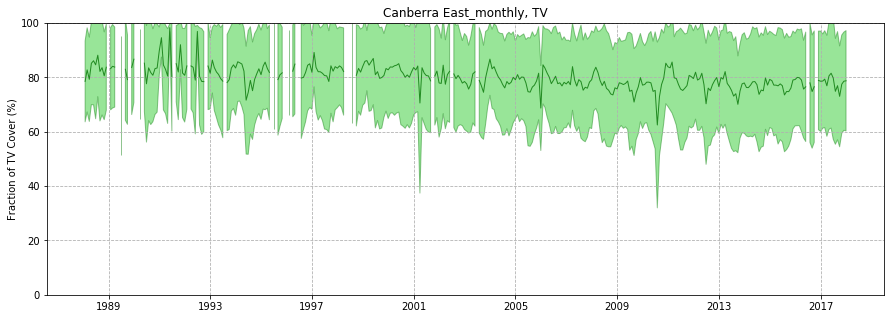

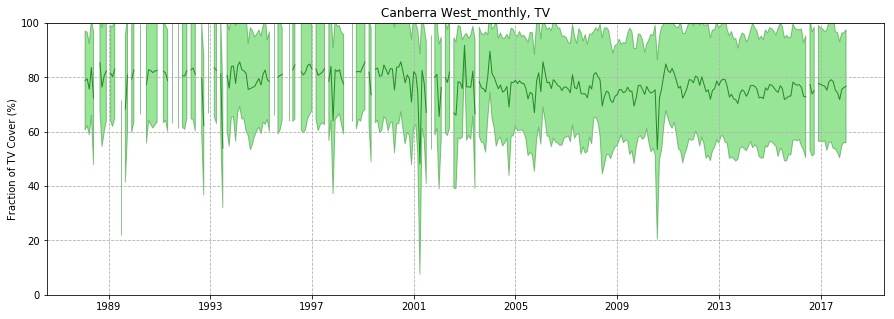

In [17]:
###################################################
#create plots of the zonally averaged TV timeseries
###################################################
CEA_data_monthly = []
for i in range(0,len(TV_zonalStats[feature_name])):
    x = TV_zonalStats.isel(['TV_mean','TV_std'], **{feature_name: i})
    CEA_data_monthly.append(x)
    
#extract the unique names of each polygon
CEA_monthly = list(TV_zonalStats[feature_name].values)

#zip the both the CEAs and CEA_data together as a dictionary 
monthly_dict = dict(zip(CEA_monthly,CEA_data_monthly))

#create a function for generating the plots
def plotResults(data, title):
    """a function for plotting up the results of the
    fractional cover change and exporting it out as pdf """
    x = data.time.values
    TV = data.TV_mean
    TV_error = data.TV_std

    #plot TV
    plt.figure(figsize=(15,5))
    plt.plot(x, TV,'k', color='#228b22', linewidth = 1)
    plt.fill_between(x, TV-TV_error, TV+TV_error,
                          alpha=0.5, edgecolor='#228b22', facecolor='#32cd32')
    plt.grid(True, linestyle ='--')
    plt.ylabel('Fraction of TV Cover (%)')
    plt.ylim(0,100)
    plt.title(title + ', TV')

    plt.savefig(results_ts_pdf +title+".pdf", bbox_inches='tight')

#loop over the dictionaries and create the plots
{key: plotResults(monthly_dict[key], key + '_monthly') for key in monthly_dict}  

In [18]:
#merge all the exported timeseries pdfs into one document
from PyPDF2 import PdfFileMerger
os.chdir(results_ts_pdf) #navigate to directory
pdfs = os.listdir() #list all the pdfs in the directory
pdfs = sorted(pdfs)

#merge the pdfs
merger = PdfFileMerger()
for pdf in pdfs:
    merger.append(pdf)
merger.write("b_all_timeseries.pdf")

#move the merged pdf into the directory above it (helps with merge of all the results later)
os.rename(results_ts_pdf+"b_all_timeseries.pdf", results_pdf+'b_all_timeseries.pdf')
os.chdir(working_directory) #navigate back to our wd

## Pixel-wise plots
<a id="pixel-wise_plots"> </a>

In [19]:
########################
#Create pixel-wise plots
########################

#import files
no_regen_intraannual = xr.open_dataset(results_netcdf + 'noRegen_intraannual.nc', decode_times=False)
no_regen_intraannual = no_regen_intraannual.drop(labels = 'time_bnds')

mean_yearly_std_diff = xr.open_dataset(results_netcdf + 'mean_yearly_std_diff.nc', decode_times=False)
mean_yearly_std_diff = mean_yearly_std_diff.TV
mean_yearly_std_diff = mean_yearly_std_diff.squeeze('time')

mean_diff = xr.open_dataset(results_netcdf + 'mean_diff.nc', decode_times=False)
mean_diff = mean_diff.TV
mean_diff = mean_diff.squeeze('time')

p_value = xr.open_dataset(results_netcdf + 'p_value.nc', decode_times=False)

p_value_levene = xr.open_dataset(results_netcdf + 'p_values_levene.nc', decode_times=False)

rgb_changeDetect = xr.open_dataset(results_netcdf + 'rgb_changeDetect.nc', decode_times=False)


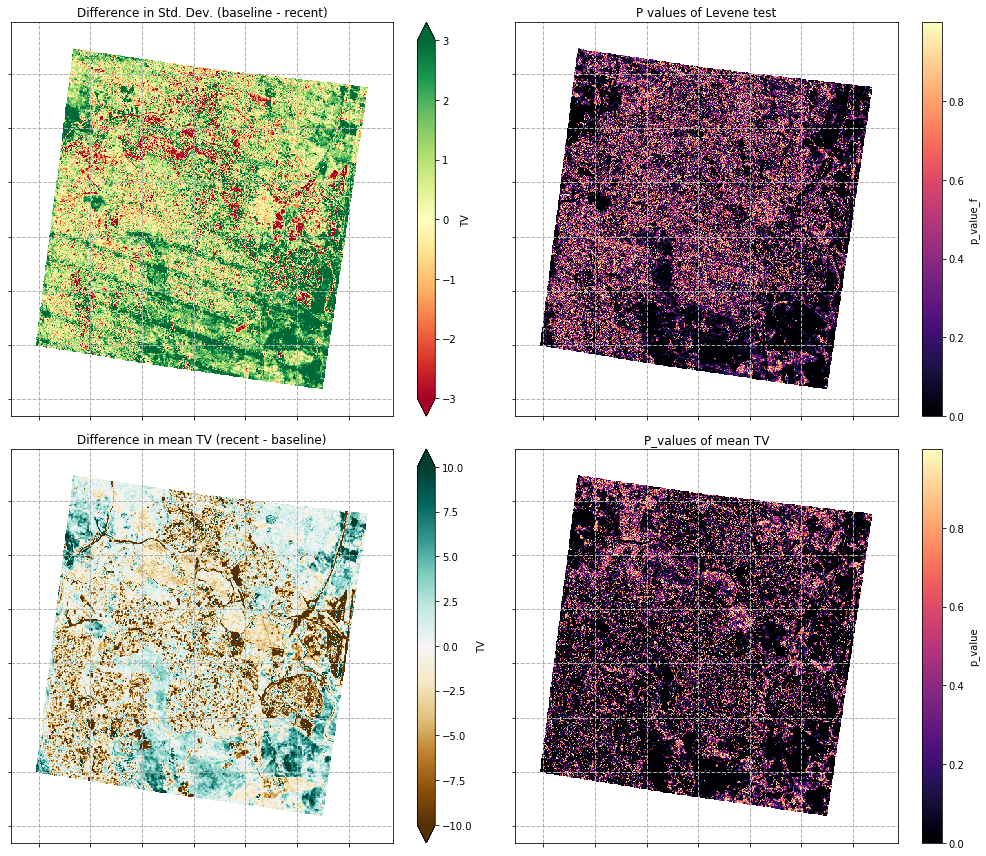

In [20]:
#create a plot showing the Std. Dev,. difference and mean difference maps, as well as the P-values for those changes.

#generate some x and y limits so the plotting is constrained
y = project_area_CEA.total_bounds
#longitude
ind = [0,2]
xlim = y[ind]  + [-1000, 1000]
xlim = tuple(xlim)
#latitude
ind1 = [1,3]
ylim = y[ind1] + [-1000, 1000]
ylim = tuple(ylim)

#plot
from matplotlib import cm
plt.figure(figsize=(14,12))
plt.subplot(221)
mean_yearly_std_diff.plot(cmap='RdYlGn', vmin=-3,vmax=3)
plt.xlim(xlim)
plt.xlabel('')
plt.ylabel('')
plt.ylim(ylim)
plt.grid(linestyle='dashed', linewidth=1,alpha=1)
plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.title('Difference in Std. Dev. (baseline - recent)')

plt.subplot(222)
p_value_levene.p_value_f.plot(cmap='magma')
ax=plt.subplot(222)
plt.xlim(xlim)
plt.xlabel('')
plt.ylabel('')
plt.ylim(ylim)
plt.grid(linestyle='dashed', linewidth=1,alpha=1)
plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.title('P values of Levene test')

plt.subplot(223)
mean_diff.plot(cmap='BrBG', vmin=-10.0,vmax=10.0)
plt.xlim(xlim)
plt.xlabel('')
plt.ylabel('')
plt.ylim(ylim)
plt.grid(linestyle='dashed', linewidth=1,alpha=1)
plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.title('Difference in mean TV (recent - baseline)')

plt.subplot(224)
p_value.p_value.plot(cmap='magma')
ax=plt.subplot(224)
plt.xlim(xlim)
plt.xlabel('')
plt.ylabel('')
plt.ylim(ylim)
plt.grid(linestyle='dashed', linewidth=1,alpha=1)
plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.title('P_values of mean TV')

plt.tight_layout()

plt.savefig(results_pdf + "c_pixel_wise_plots.pdf", bbox_inches='tight')


In [21]:
#Calculate the number of cells that are at a high-risk of no-regeneration for the std dev method
#we want to calculate this for the method where I do take account of the p-values_levene, and the where we don't

#Method ingnoring levene stats results
ones = (no_regen_intraannual.noRegen.values == 1).sum()
no_of_cells = np.count_nonzero(~np.isnan(no_regen_intraannual.noRegen.values))
risk_percent = round(ones/no_of_cells*100, 2)
risk_percent = risk_percent.astype(str)

#Method incorporating levene stats results
ones_masked = np.array(no_regen_intraannual.noRegen.where(p_value_levene.p_value_f<=0.10) == 1).sum()
risk_percent_masked = round(ones_masked/no_of_cells*100, 2)
risk_percent_masked = risk_percent_masked.astype(str)

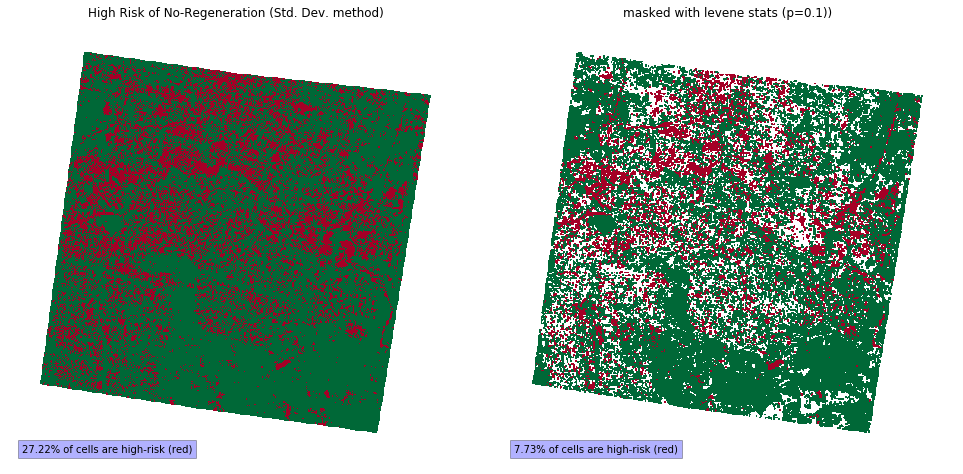

In [22]:
fig = plt.figure(figsize=(15,15))
t = (risk_percent +"% of cells are high-risk (red)")
plt.subplot(121)
no_regen_intraannual.noRegen.plot(cmap='RdYlGn_r')
ax=plt.subplot(121)
plt.text(0.025, 0.025, t,
        transform = ax.transAxes, 
        bbox=dict(facecolor='blue', alpha=0.3),
        wrap=True)
plt.xlim(xlim)
plt.xlabel('')
plt.ylabel('')
plt.ylim(ylim)
ax.set_axis_off()
fig.delaxes(fig.axes[1])
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.grid(linestyle='dashed', linewidth=1,alpha=1)
plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('High Risk of No-Regeneration (Std. Dev. method)')

t1 = (risk_percent_masked +"% of cells are high-risk (red)")
plt.subplot(122)
no_regen_intraannual.noRegen.where(p_value_levene.p_value_f<=0.10).plot(cmap='RdYlGn_r')
ax1=plt.subplot(122)
plt.text(0.025, 0.025, t1,
        transform = ax1.transAxes, 
        bbox=dict(facecolor='blue', alpha=0.3),
        wrap=True)
plt.xlim(xlim)
fig.delaxes(fig.axes[2])
plt.axis('off')
plt.xlabel('')
plt.ylabel('')
plt.ylim(ylim)
plt.grid(linestyle='dashed', linewidth=1,alpha=1)
plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.title('masked with levene stats (p=0.1))')
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

plt.savefig(results_pdf + "d_no_regeneration_stdDev_method.pdf", bbox_inches='tight')

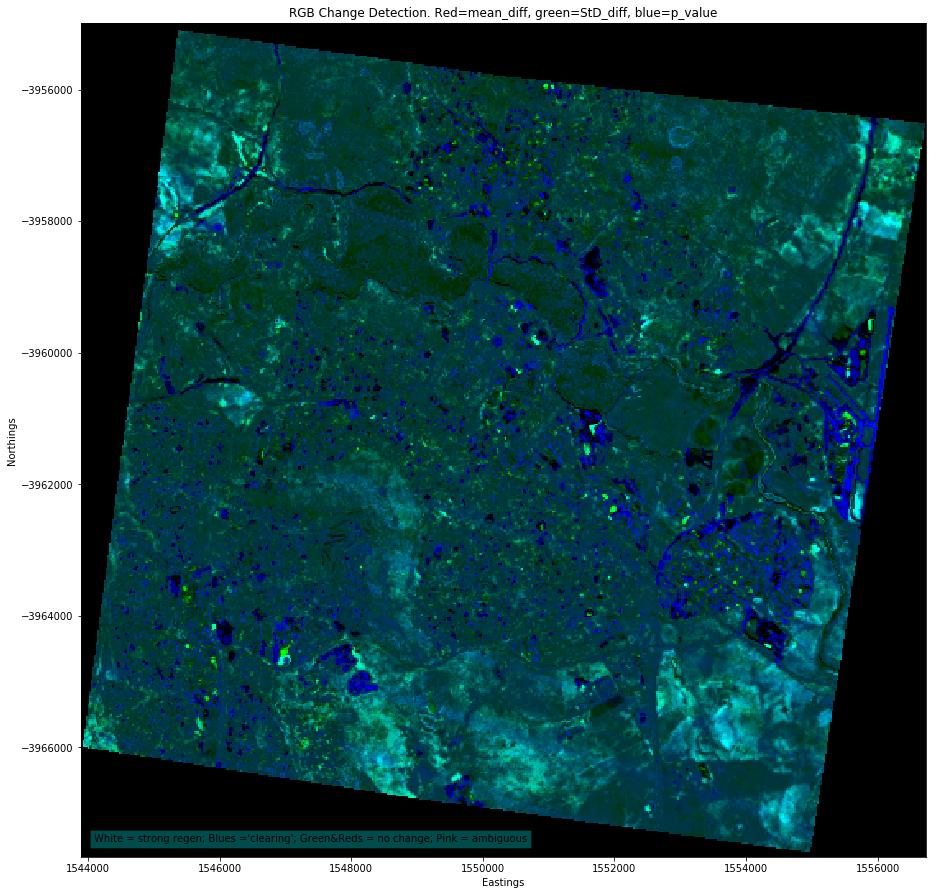

In [23]:
#make the final plot that has 3 of the layers combined
from skimage.exposure import rescale_intensity
from skimage import exposure
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

x = rgb_changeDetect.to_array().data
img = np.transpose(x,[1,2,0]).copy()
for b in range(img.shape[2]):
    tmp = img[:,:,b]
#     pl, pu = np.percentile(tmp[np.isfinite(tmp)], (10., 90.))
    mu = np.nanmedian(tmp)
    sd = np.nanstd(tmp)
    pl, pu = mu - 2.5*sd, mu + 2.5*sd
    img[:,:,b] = rescale_intensity(tmp, in_range=(pl, pu), out_range=(0., 1.))

xmin= int(rgb_changeDetect.coords['x'].min().values) + 200
xmax= int(rgb_changeDetect.coords['x'].max().values) + 200
ymin = int(rgb_changeDetect.coords['y'].min().values) + 200
ymax= int(rgb_changeDetect.coords['y'].max().values) + 200    
    
# plt.figure(figsize = (13.0, 13.0))
fig, ax = plt.subplots(figsize = (13.0, 13.0))
plt.imshow(img, interpolation='nearest',extent = [rgb_changeDetect.coords['x'].min(), rgb_changeDetect.coords['x'].max(),
                          rgb_changeDetect.coords['y'].min(), rgb_changeDetect.coords['y'].max()])
plt.title('RGB Change Detection. Red=mean_diff, green=StD_diff, blue=p_value')
plt.text(xmin,ymin,"White = strong regen; Blues ='clearing'; Green&Reds = no change; Pink = ambiguous" , bbox=dict(facecolor='cyan', alpha=0.3)
        , horizontalalignment='left', verticalalignment='bottom', wrap=True)
plt.xlabel('Eastings')
plt.ylabel('Northings')
ax.set_facecolor('black')
#--Add an image to the plot---------------------------------
# rgb_tri = plt.imread((data+'rgbtri.png'), format='png')
# newax = fig.add_axes([0.745, 0.215, 0.15, 0.15], zorder=2)
# newax.imshow(rgb_tri)
# newax.axis('off')
#-----------------------------------------------------------
plt.tight_layout()
plt.savefig(results_pdf + "e_rgb_changeDetect.pdf", bbox_inches='tight')

## True colour plot
<a id="truecolourplot"> </a>

In [24]:
#import a recent landsat image to use for a truecolour plot
query_new = {'time': ('2018-01-01', '2018-03-28'),}
query_new['x'] = extent_long
query_new['y'] = extent_lat

recent_image = load_clearlandsat(dc=datacube.Datacube(app='loadrecentimage'),
                          sensors=['ls8'],
                          query=query_new,
                          masked_prop=0.95)

red = recent_image.red
green = recent_image.green
blue = recent_image.blue

from datacube.utils.geometry import CRS
from affine import Affine
rgb={'red':red, 'green':green, 'blue':blue}
rgb_xr = xr.Dataset(rgb, attrs={'crs' : CRS('EPSG:3577'),'affine': recent_image.affine })

#export the truecolour plot as a geotiff
dataset_to_geotiff(tiff_results + 'a_trueColour.tif',rgb_xr.isel(time=0))

Loading ls8 PQ
    Loading 1 filtered ls8 timesteps
Combining and sorting ls5, ls7 and ls8 data


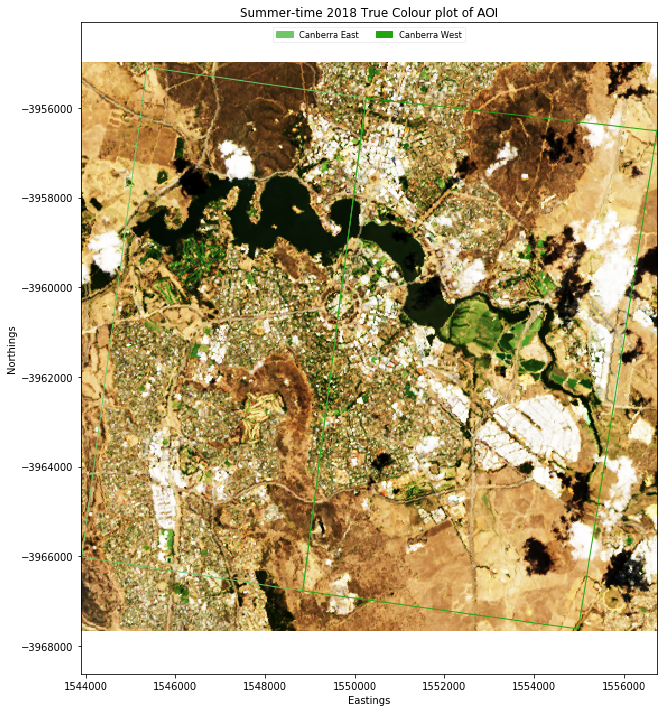

In [25]:
#create plot using the custom function 'three_band_image'
plt, fig = three_band_image(recent_image, time=0, bands=['red', 'green', 'blue'], contrast_enhance=True)    

#bring in shapefile
import fiona
with fiona.open(project_area_CEA_albers_loc, 'r') as shapefile:
    features = [feature["geometry"] for feature in shapefile]
ax = plt.gca()

#create a long list of colors to iterate over in the plot shapefile code
from random import randint
colors = []
for i in range(100):
    colors.append('#%06X' % randint(0, 0xFFFFFF))

#plot the shapefile
from descartes import PolygonPatch
import matplotlib as mpl
patches = [PolygonPatch(feature, 
                        facecolor="none", 
                        linewidth=1,label='Label') for feature in features]
ax.add_collection(mpl.collections.PatchCollection(patches, edgecolor=[color for color in colors], match_original=True))

#create a nice, custom legend
import matplotlib.patches as mpatches
texts = list(project_area_CEA.index)
patches = [mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, loc=9, ncol=2, fontsize='small', fancybox=True, framealpha=0.3)

#make it pretty
plt.title('Summer-time 2018 True Colour plot of AOI')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.ylim(ylim)
plt.tight_layout()
plt.savefig(results_pdf + "a_true_colour.pdf", bbox_inches='tight')

## Merge all pdfs
<a id="mergeallpdfs"> </a>

In [26]:
#merge all the pdfs into a final results document
from PyPDF2 import PdfFileMerger
os.chdir(results_pdf)

#get list of files in the directory that are pdfs
pdfs = []
for file in os.listdir():
    if file.endswith(".pdf"):
        pdfs.append(os.path.join(file))
pdfs = sorted(pdfs)

#merge pdfs
merger = PdfFileMerger()
for pdf in pdfs:
    merger.append(pdf)

merger.write("final_results.pdf")

os.chdir(working_directory)